In [1]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
import PIL
from functools import partial
from PIL import Image
from nimbus.common.parallel import parallelize

In [2]:
with open('coords_raw_text.txt') as f:
    end_points = np.array([tuple(map(lambda x: float(x), line.strip().removeprefix('\\psdots[dotstyle=*,linecolor=ududff](').removesuffix(')').split(',')))
              for line in f.readlines()])
    start_points = np.random.normal(loc=0, scale=0.5, size=end_points.shape)

In [3]:
def fig_to_numpy(fig):
    fig.canvas.draw()
    data = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
    image = data.reshape(fig.canvas.get_width_height()[::-1] + (4,))
    return image

In [46]:
def optimal_transport(start_points, end_points, t):
    fig, ax = plt.subplots(1, subplot_kw=dict(aspect='equal'))
    ax.grid()
    mid_points = t * end_points + (1. - t) * start_points
    ax.scatter(start_points[:,0], start_points[:,1], s=3, color='red')
    ax.scatter(mid_points[:,0], mid_points[:,1], s=3, color='royalblue')
    ax.scatter(end_points[:,0], end_points[:,1], s=3, color='k')
    [ax.plot([s[0], e[0]], [s[1], e[1]], c='royalblue', linewidth=0.5, alpha=0.5, zorder=-1)[0]
        for s, e in zip(start_points, mid_points)]
    return fig_to_numpy(fig)
def helper_optimal_transport(args):
    return optimal_transport(start_points=args['start_points'], end_points=args['end_points'], t=args['t'])

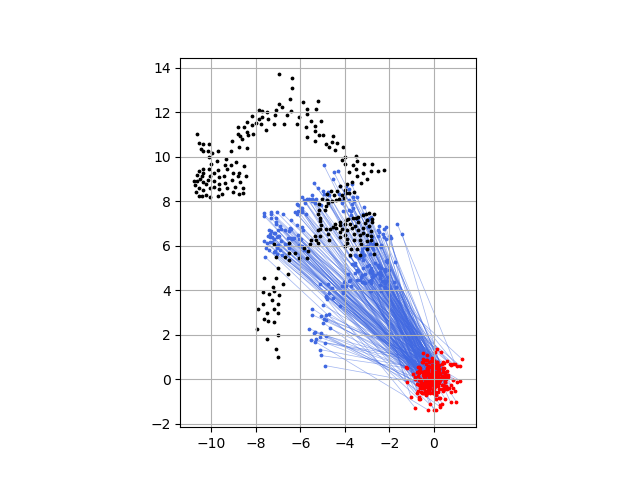

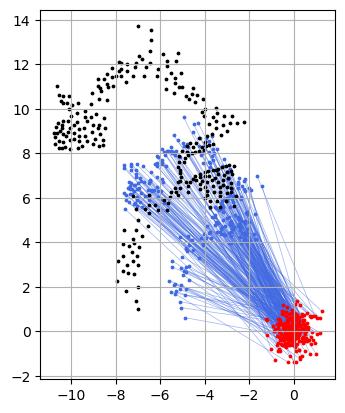

In [48]:
Image.fromarray(optimal_transport(start_points=start_points, end_points=end_points, t=0.7))

In [12]:
ret = parallelize(helper_optimal_transport, args=[dict(start_points=start_points, end_points=end_points, t=t) for t in np.linspace(0,1,100)])
pil_images = [Image.fromarray(r) for r in ret]

  0%|                                                                                                                           | 0/100 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.10it/s]


In [17]:
pil_images[0].save('mapping.gif', save_all=True, append_images=pil_images[1:] + [pil_images[-1]] * 20, duration=80, loop=0)

In [24]:
def diffeo(x, y, t):
    """
    Smooth 2D diffeomorphism with controllable intensity.
    intensity ~0.1 = slight warp, ~1.5 = stronger expansion.
    """
    intensity = t * 8
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)

    # Swirl effect (localized)
    swirl_strength = 0.3 * intensity
    theta_new = theta + swirl_strength * np.exp(-0.05 * r**2)

    # Expansion effect (monotone, no folding)
    expand_strength = -0.05 * intensity
    scale = 1 + expand_strength * (r**2 / (1 + r**2))  # smooth growth, saturates for large r

    # Map back to Cartesian
    x_new = r * np.cos(theta_new) * scale - t * 3
    y_new = r * np.sin(theta_new) * scale + t * 2
    return x_new, y_new
    # return x_new - 3, y_new + 2


def plot_mesh(ax, x, y):
    PLOT_LW = 1
    N = x.shape[0]
    for i in range(N):
        ax.plot(x[i,:], y[i,:], color='blue', lw=PLOT_LW, alpha=0.2)
        ax.plot(x[:,i], y[:,i], color='blue', lw=PLOT_LW, alpha=0.2)

    ax.axvline(0, zorder=-10, alpha=0.5, c='gray', lw=PLOT_LW)
    ax.axhline(0, zorder=-10, alpha=0.5, c='gray', lw=PLOT_LW)

def labeled_scatter(ax, x, y, label):
    ax.scatter(x, y, color='royalblue', zorder=5, s=5)
    ax.text(x+0.2, y, label, color='k', fontsize=18)

In [19]:
# Make a grid
n = 200
x = np.linspace(-20, 20, n)
y = np.linspace(-20, 20, n)
X, Y = np.meshgrid(x, y)

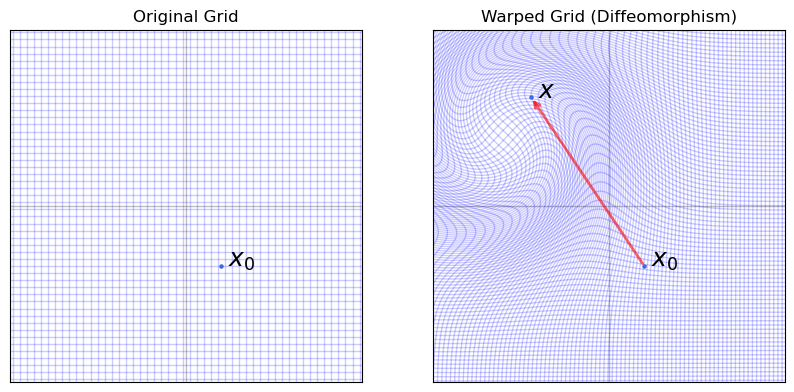

In [25]:

# Plot
fig, axs = plt.subplots(1, 2, figsize=(10, 5), subplot_kw=dict(xticks=[], yticks=[], xlim=(-5,5), ylim=(-5,5), aspect='equal'))


t = 1
# Apply diffeomorphism
X_new, Y_new = diffeo(X, Y, t=t)
# Point of interest
x0, y0 = 1, -1.7
x_map, y_map = diffeo(x0, y0, t=t)

axs[1].annotate(
        '',                # No text
        xy=(x_map, y_map),       # Arrow tip
        xytext=(x0, y0),   # Arrow start
        arrowprops=dict(
            arrowstyle='->',  # Simple arrow
            color='r',
            linewidth=2, alpha=0.6
        )
    )

plot_mesh(axs[0], X, Y)
plot_mesh(axs[1], X_new, Y_new)


axs[0].set_title("Original Grid")
axs[1].set_title("Warped Grid (Diffeomorphism)")

labeled_scatter(axs[0], x0, y0, label=r'$x_0$')
labeled_scatter(axs[1], x0, y0, label=r'$x_0$')
labeled_scatter(axs[1], x_map, y_map, label=r'$x$')

plt.show()


In [ ]:
def diffeomorphism(t):
    fig, ax = plt.subplots(1, subplot_kw=dict(xticks=[], yticks=[], xlim=(-5,5), ylim=(-5,5), aspect='equal'))
    X_new, Y_new = diffeo(X, Y, t=t)
    # map 
    x_map, y_map = diffeo(x0, y0, t=t)
    plot_mesh(ax, X_new, Y_new)
    labeled_scatter(ax, x0, y0, label=r"$x_0$")
    labeled_scatter(ax, x_map, y_map, label=r"$x$")
    # flow arrow
    ax.annotate(
        '',                # No text
        xy=(x_map, y_map),       # Arrow tip
        xytext=(x0, y0),   # Arrow start
        arrowprops=dict(
            arrowstyle='->',  # Simple arrow
            color='r',
            linewidth=2, alpha=0.6
        )
    )
    # vector arrow
    v = 10 * (np.array(diffeo(x0, y0, t=t+0.01)) - np.array([x_map, y_map])) + np.array([x_map, y_map])
    ax.annotate(
        '',                # No text
        xy=(v[0], v[1]), # Arrow tip
        xytext=(x_map, y_map),   # Arrow start
        arrowprops=dict(
            arrowstyle='->',  # Simple arrow
            color='green',
            linewidth=2, alpha=1
        )
    )
    ax.set_title(rf"$t={t:.02f}$")
                                                                                 
    return fig_to_numpy(fig)
def helper_diffeomorphism(args):
    return diffeomorphism(args['t'])

In [35]:
ret = parallelize(helper_diffeomorphism, args=[dict(t=t) for t in np.linspace(0,0.99,100)])
pil_images = [Image.fromarray(r) for r in ret]
pil_images[0].save('diffeomorphism.gif', save_all=True, append_images=pil_images[1:] + [pil_images[-1]] * 20, duration=80, loop=0)

  0%|                                                                                                                           | 0/100 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.83it/s]


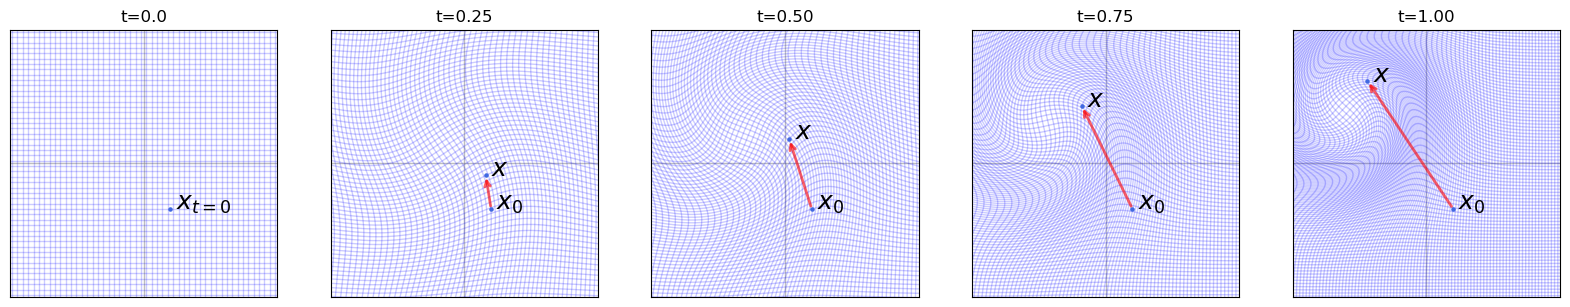

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(20, 4), subplot_kw=dict(xticks=[], yticks=[], xlim=(-5,5), ylim=(-5,5), aspect='equal'))
plot_mesh(axs[0], X, Y)

# Point of interest
x0, y0 = 1, -1.7
labeled_scatter(axs[0], x0, y0, label=rf"$x_{{t=0}}$")
for i, ax in enumerate(axs[1:].flatten()):
    t = 0.25 * (i + 1)
    x_map, y_map = diffeo(x0, y0, t=t)
    X_new, Y_new = diffeo(X, Y, t=t)
    plot_mesh(ax, X_new, Y_new)
    labeled_scatter(ax, x0, y0, label=r"$x_0$")
    labeled_scatter(ax, x_map, y_map, label=r"$x$")

    ax.annotate(
        '',                # No text
        xy=(x_map, y_map),       # Arrow tip
        xytext=(x0, y0),   # Arrow start
        arrowprops=dict(
            arrowstyle='->',  # Simple arrow
            color='r',
            linewidth=2, alpha=0.6
        )
    )
    ax.set_title(f"{t=:.02f}")
axs[0].set_title("t=0.0")
pass